# Astronomical Coordinates

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from astropy.coordinates import SkyCoord, Distance, Galactic
from astroplan.plots import plot_finder_image

from astropy.table import QTable
from astroquery.gaia import Gaia

## International Celestial Reference System (ICRS)

- The standard celestial reference system adopted by the International Astronomical Union (IAU). 
- Its origin is at the barycenter of the Solar System.
- Sometimes referred to as "equatorial" or "J2000" coordinates

## Declination (DEC or δ)

- Equivalent to terrestrial latitude. 
- Points north of the celestial equator have positive declinations, while those to the south have negative declinations. 
- Declination is expressed in degrees [°], arc-minutes [ ′ ], and arc-seconds [ ′′ ].
- 1° = 60′ = 3600′′

#### Example: DEC = +23° 52′ 12.12′′

## Right Ascension (RA or α) 

- Roughly equivalent to terrestrial longitude. 
- The units of right ascension are hours, minutes, seconds [hms].
- 1 hour in RA = 15°, 24 hours in RA = 360°

#### Example: RA = 20h 23m 12.12s

---

### Target - M67 (NGC 2682)

&nbsp;

<p>
<img src="https://uwashington-astro300.github.io/A300_images/M67_Finder_Chart.png" width = "500">
</p>

- Right ascension: 08h 51m 23s
- Declination: +11° 48′ 50″

## `SkyCoord(Coord, Frame)`

In Astropy, the most common way of representing and working with sky coordinates is to use `SkyCoord()`.

In [2]:
target_coords = SkyCoord('08h51m23s', '+11d48m50s', frame='icrs')
target_coords

<SkyCoord (ICRS): (ra, dec) in deg
    (132.84583333, 11.81388889)>

In [3]:
target_coords = SkyCoord('08:51:23 11:48:50', unit=(u.hour, u.deg), frame='icrs')
target_coords

<SkyCoord (ICRS): (ra, dec) in deg
    (132.84583333, 11.81388889)>

In [4]:
target_coords.ra

<Longitude 132.84583333 deg>

In [5]:
target_coords.ra.hour

8.856388888888889

In [6]:
target_coords.ra.hms

hms_tuple(h=8.0, m=51.0, s=22.99999999999912)

In [7]:
target_coords.ra.degree

132.8458333333333

In [8]:
target_coords.dec

<Latitude 11.81388889 deg>

In [9]:
target_coords.dec.degree

11.81388888888889

In [10]:
target_coords.ra.degree, target_coords.dec.degree

(132.8458333333333, 11.81388888888889)

### Or you can use `SkyCoord.from_name()` and let [Simbad](https://simbad.u-strasbg.fr/simbad/) do all the work for you.

In [11]:
target_coords = SkyCoord.from_name('M 67')
target_coords

<SkyCoord (ICRS): (ra, dec) in deg
    (132.846, 11.814)>

In [12]:
target_coords = SkyCoord.from_name('NGC 2682')
target_coords

<SkyCoord (ICRS): (ra, dec) in deg
    (132.846, 11.814)>

---

## Palomar Observatory Sky Survey (POSS)

The Palomar Observatory Sky Survey (POSS) was a major astronomical survey, that took almost 2,000 photographic plates of the night sky that was completed by the end of 1958. The photographs were taken with the 48-inch Samuel Oschin telescope at Palomar Observatory.

<p>
    <img src="https://uwashington-astro300.github.io/A300_images/HubbleSchmitt.jpg" width = "200">
</p>

The survey utilized 14-inch square photographic plates, covering about 6° of sky per side. Each region of the sky was photographed twice, once using a red plate, and once with a blue sensitive plate.

POSS was mostly completed just proir to the launch of Sputnik 1 on October 4, 1957, meaning the original POSS prints have NO satellite trails on them.

The POSS was published as a collection of 1,872 photographic negative prints each measuring 14" x 14". The original cost was ~ \\$15,000 plus \\$1,650 for the transparent coordinate overlays.


<p>
    <img src="https://uwashington-astro300.github.io/A300_images/POSS_1.jpg" width = "400">
    <img src="https://uwashington-astro300.github.io/A300_images/POSS_2.jpg" width = "400">
</p>

The [Digitized Sky Survey (DSS)](https://archive.stsci.edu/cgi-bin/dss_form) is a digitized version of the Palomar and UK Schmidt surveys, produced by the Space Telescope Science Institute.

- The First Generation DSS (DSS1) was published (on 102 CD-ROMs for \\$3,500) in 1994
- The Second Generation DSS (DSS2) was published online in 2006

## Pretty Pictures

- You can use the `plot_finder_image()` function from the `astroplan` package to get a DSS image of your target object.


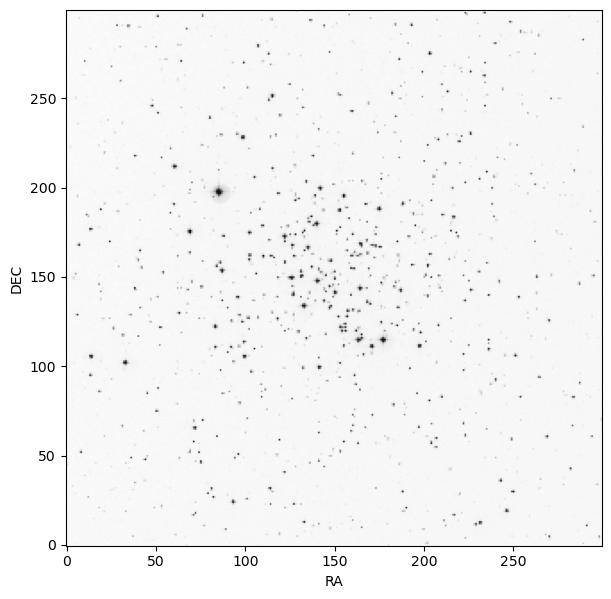

In [13]:
fig, ax = plt.subplots(
    figsize = (6, 6), 
    constrained_layout = True
)

ax, hdu = plot_finder_image(
    target_coords, 
    fov_radius= 0.5 * u.deg, 
    ax = ax,
    survey = 'DSS2 Blue'
);

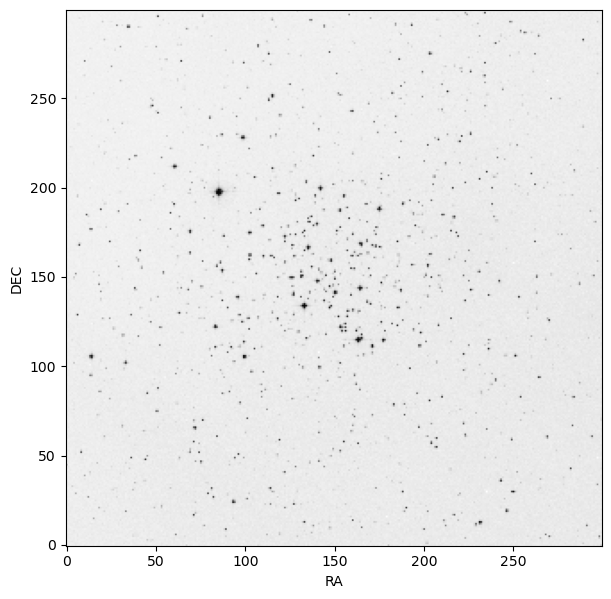

In [14]:
fig, ax = plt.subplots(
    figsize = (6, 6), 
    constrained_layout = True
)

ax, hdu = plot_finder_image(
    target_coords, 
    fov_radius= 0.5 * u.deg, 
    ax = ax,
    survey = 'DSS2 IR'
);

---

## Getting Good Gaia Data

We have only used a small subset of the data availible in the `gaia_source_lite` database. Let's grab a few more columns to increase the quality of our data:

[gaia_source_lite data columns](https://gaia.aip.de/metadata/gaiadr3/gaia_source_lite/)

```
parallax_over_error         Parallax divided by its standard error
pmra                        Proper motion in right ascension direction
pmdec                       Proper motion in declination direction
radial_velocity             Radial velocity
```

The `parallax_over_error` column will allow use to get high quality parallax data. 

- It is very common to judge the quality of data by comparing the data (signal) to the error in the data (noise). 
- The ratio of the data / error is often called the signal-to-noise ratio (SNR). 
- The SNR for data is often referred to by a lower case sigma (σ)

The `parallax_over_error` column is the SNR for the parallax data.

What is considered a good SNR really depends on the particular situation. 

- As a very general rule of thumb is that a SNR of 10 (10σ) is high quality data. 
- A SNR of 3 (3σ) is considered "barely detected".

## Gaia query for 10σ data for our target

In [15]:
my_query = f"""
SELECT TOP 3000
source_id, ra, dec, parallax, parallax_over_error, pmra, pmdec, radial_velocity
FROM gaiadr3.gaia_source_lite
WHERE DISTANCE( POINT({target_coords.ra.degree}, {target_coords.dec.degree}), POINT(ra, dec) ) < 0.5
AND parallax_over_error > 10
ORDER BY parallax DESC
"""

In [16]:
print(my_query)


SELECT TOP 3000
source_id, ra, dec, parallax, parallax_over_error, pmra, pmdec, radial_velocity
FROM gaiadr3.gaia_source_lite
WHERE DISTANCE( POINT(132.846, 11.814), POINT(ra, dec) ) < 0.5
AND parallax_over_error > 10
ORDER BY parallax DESC



In [17]:
my_job_query = Gaia.launch_job(my_query)

In [18]:
print(my_job_query)

<Table length=1782>
        name         dtype    unit                              description                             n_bad
------------------- ------- -------- ------------------------------------------------------------------ -----
          source_id   int64          Unique source identifier (unique within a particular Data Release)     0
                 ra float64      deg                                                    Right ascension     0
                dec float64      deg                                                        Declination     0
           parallax float64      mas                                                           Parallax     0
parallax_over_error float32                                      Parallax divided by its standard error     0
               pmra float64 mas / yr                         Proper motion in right ascension direction     0
              pmdec float64 mas / yr                             Proper motion in declination direct

In [19]:
target_table = my_job_query.get_results()

In [20]:
target_table[0:2]

source_id,ra,dec,parallax,parallax_over_error,pmra,pmdec,radial_velocity
,deg,deg,mas,,mas / yr,mas / yr,km / s
int64,float64,float64,float64,float32,float64,float64,float32
598889625574643456,132.74809887386834,11.513790663570646,22.044759098763794,558.68115,-229.43830193224062,11.984484545666625,53.319298
604974322923169152,132.66487216005032,12.04251345658294,17.40886546057584,1000.03986,139.24034634961,-36.29515410375184,-37.5526


In [21]:
target_table['Distance'] = target_table['parallax'].to(u.parsec, equivalencies=u.parallax())

In [22]:
target_table[0:2]

source_id,ra,dec,parallax,parallax_over_error,pmra,pmdec,radial_velocity,Distance
,deg,deg,mas,,mas / yr,mas / yr,km / s,pc
int64,float64,float64,float64,float32,float64,float64,float32,float64
598889625574643456,132.74809887386834,11.513790663570646,22.044759098763794,558.68115,-229.43830193224062,11.984484545666625,53.319298,45.36225574159606
604974322923169152,132.66487216005032,12.04251345658294,17.40886546057584,1000.03986,139.24034634961,-36.29515410375184,-37.5526,57.4419971401699


## Quality parallax means quality distances

In [23]:
from mpl_toolkits.mplot3d import Axes3D

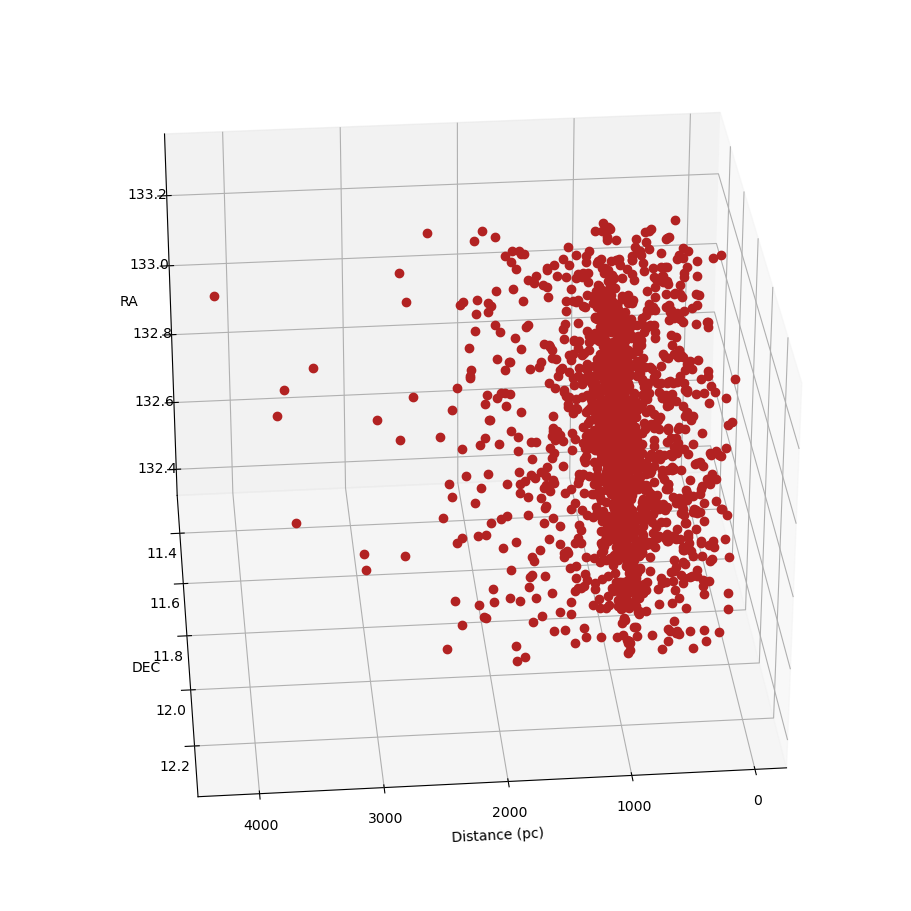

In [24]:
fig, ax = plt.subplots(
    subplot_kw={'projection': '3d'},
    figsize = (9, 9), 
    constrained_layout = True
)

ax.set_xlabel('Distance (pc)')
ax.set_ylabel('DEC')
ax.set_zlabel('RA')

my_otherx = target_table['Distance']
my_othery = target_table['dec']
my_otherz = target_table['ra']

ax.plot(my_otherx, my_othery, my_otherz,
        color = 'Firebrick',
        marker = 'o',
        linestyle = 'none');

ax.view_init(azim = 85, elev = 30)

# 3D Coords

In [25]:
target_3d_coords = SkyCoord(
    ra =target_table['ra'],
    dec = target_table['dec'],
    distance = target_table['Distance'],
    frame = 'icrs')

In [26]:
target_3d_coords[0:2]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(132.74809887, 11.51379066, 45.36225574),
     (132.66487216, 12.04251346, 57.44199714)]>

## Galactic Coordinates

A coordinate system based
on the plane of the galaxy. It is centred on the Sun,
and longitude and latitude 0 point directly towards
the centre of the galaxy. Galactic longitude (l) is
measured with primary direction from the Sun to the
center of the galaxy in the galactic plane, while the
galactic latitude (b) measures the angle of the object
above the galactic plane.

<p>
<img src="https://uwashington-astro300.github.io/A300_images/GalCoords.png" width = "800">
</p>

In [27]:
target_3d_coords_gal = target_3d_coords.galactic

In [28]:
target_3d_coords_gal[0:2]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [(215.96443491, 31.70772894, 45.36225574),
     (215.3594788 , 31.85514907, 57.44199714)]>

In [29]:
target_3d_coords_gal.l.deg

array([215.96443491, 215.3594788 , 215.92401653, ..., 216.02705065,
       215.65027983, 215.86247245])

In [30]:
target_3d_coords_gal.b.deg

array([31.70772894, 31.85514907, 32.37164142, ..., 31.59833776,
       32.25157528, 32.37047904])

# 3D-Time Coords

In [31]:
from astropy.time import Time

In [33]:
target_3d_coords = SkyCoord(
    ra =target_table['ra'],
    dec = target_table['dec'],
    distance = target_table['Distance'],
    pm_ra_cosdec = target_table['pmra'],
    pm_dec = target_table['pmdec'],
    radial_velocity = target_table['radial_velocity'],
    obstime = Time('2023-11-', format='yr'),
    frame = 'icrs')

ValueError: Format 'yr' is not one of the allowed formats ['byear', 'byear_str', 'cxcsec', 'datetime', 'datetime64', 'decimalyear', 'fits', 'gps', 'iso', 'isot', 'jd', 'jyear', 'jyear_str', 'mjd', 'plot_date', 'stardate', 'unix', 'unix_tai', 'yday', 'ymdhms']

In [ ]:
target_3d_coords[0]

## With full 3D-Time coordinartes we can calculate the coordinates at future times

- `.apply_space_motion()`

In [ ]:
new_time = target_3d_coords.apply_space_motion(new_obstime = Time(2087.0, format='jyear'))

In [ ]:
new_time[0]

## Some `matplotlib` Stuff

In [ ]:
fig, ax = plt.subplots(
    figsize = (6, 6), 
    constrained_layout = True
)

my_view_radius = 0.10

ax.set_xlim(target_coords.ra.degree + my_view_radius, target_coords.ra.degree - my_view_radius)
ax.set_ylim(target_coords.dec.degree - my_view_radius, target_coords.dec.degree + my_view_radius)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.scatter(
    target_table['ra'], target_table['dec'],
    color = 'hotpink',
    marker = '*'
);

In [ ]:
fig, ax = plt.subplots(
    figsize = (6, 6), 
    constrained_layout = True
)

my_view_radius = 0.10

ax.set_xlim(target_coords.ra.degree + my_view_radius, target_coords.ra.degree - my_view_radius)
ax.set_ylim(target_coords.dec.degree - my_view_radius, target_coords.dec.degree + my_view_radius)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')


ax.scatter(
    target_table['ra'], target_table['dec'],
    color = 'hotpink',
    marker = '*'
)

ax.quiver(
    np.array(target_table['ra']), np.array(target_table['dec']), 
    np.array(target_table['pmra']) / 100 , np.array(target_table['pmdec']) /  100,
    scale = 1
);